# CSTR: Rolling Horizon Simulation

This is a Pyomo version of the simulation used in Pilario and Cao (2018). IEEE Trans. on Industrial Informatics.
Note that the input signals and simulation time is different, and the noise is removed.

In [6]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def solve_model(ti, tf, Qc_data, Ci_data, Ti_data, init_data):

    cstr = ConcreteModel()

    cstr.ti = Param(initialize=ti)
    cstr.tf = Param(initialize=tf)
    cstr.t = ContinuousSet(bounds=(cstr.ti,cstr.tf))

    # Parameters
    V   = 150     # L, Tank volume
    Vc  = 10      # L, Jacket volume
    dH  = -2.0e5  # cal/mol, Heat of rxn
    UA  = 7.0e5   # cal/min/K, heat transfer coeff.
    k0  = 7.2e10  # 1/min, pre-exponential factor
    ER  = 1.0e4   # K, Activation energy
    rC  = 1.0e3   # cal/L/K, density * heat capacity
   
    # States
    cstr.C  = Var(cstr.t, initialize=0.1, domain=NonNegativeReals)
    cstr.T  = Var(cstr.t, initialize=430.882699002514)
    cstr.Tc = Var(cstr.t, initialize=416.723084574301)
    
    # Inputs and Disturbances
    cstr.Q   = Param(cstr.t, default=100)  # L/min, Inlet flow rate
    cstr.Tci = Param(cstr.t, default=350)  # K, Inlet coolant temp.
    
    cstr.a = Param(cstr.t, default=1.0, mutable=True) # Catalyst activity
    cstr.b = Param(cstr.t, default=1.0, mutable=True) # Fouling extent
    
    cstr.Qc = Param(cstr.t, mutable=True)  # Input to be manipulated
    cstr.Ci = Param(cstr.t, mutable=True)  # Input to be manipulated
    cstr.Ti = Param(cstr.t, mutable=True)  # Input to be manipulated
    
    # Setup derivative vars for states
    cstr.dCdt = DerivativeVar(cstr.C, initialize=init_data['dCdt'])
    cstr.dTdt = DerivativeVar(cstr.T, initialize=init_data['dTdt'])
    cstr.dTcdt = DerivativeVar(cstr.Tc, initialize=init_data['dTcdt'])

    # Set an objective
    cstr.obj = Objective(expr=1)
    
    def dCdt(m, i):
        return m.dCdt[i] == m.Q[i]/V*(m.Ci[i] - m.C[i]) - \
                            m.a[i] * k0*exp(-ER/m.T[i]) * m.C[i]
    
    def dTdt(m, i):
        return m.dTdt[i] == m.Q[i]/V*(m.Ti[i] - m.T[i]) - \
                            m.a[i] * k0*exp(-ER/m.T[i]) * m.C[i] * dH/rC - \
                            m.b[i] * UA/rC/V*(m.T[i] - m.Tc[i])
    
    def dTcdt(m, i):
        return m.dTcdt[i] == m.Qc[i]/Vc*(m.Tci[i] - m.Tc[i]) + \
                             m.b[i] * UA/rC/Vc*(m.T[i] - m.Tc[i])
    
    cstr.z1dot = Constraint(cstr.t, rule=dCdt)
    cstr.z2dot = Constraint(cstr.t, rule=dTdt)
    cstr.z3dot = Constraint(cstr.t, rule=dTcdt)

    def _init(m):
        yield m.C[cstr.ti] == init_data['C']
        yield m.T[cstr.ti] == init_data['T']
        yield m.Tc[cstr.ti] == init_data['Tc']
    
    cstr.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(cstr, nfe=50, ncp=3, scheme='LAGRANGE-RADAU')

    # Step change data
    timepoints = list(cstr.t)
    if cstr.ti.value == 0:
        Qc_data[0] = 148.5502
        Ci_data[0] = 1.
        Ti_data[0] = 350.
        
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        cstr.Qc[t] = Qc_data[pos][0]
        cstr.Ci[t] = Ci_data[pos][0]
        cstr.Ti[t] = Ti_data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(cstr)
    
    model_vars = cstr.component_map(ctype=Var)
    model_params = cstr.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        s = pd.Series(v.extract_values(), 
                      index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'Qc' or v.name == 'Ci' or v.name == 'Ti':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    cstr_df = pd.concat(s_list, axis=1)
    cstr_df.columns = col_list
    return cstr_df, res
    
np.random.seed(2)
i_data = np.arange(0, 400, 20) # start, last, increment
Qc_data = (np.random.rand(i_data.shape[0])-0.5)*5 + 148.5502
Ci_data = (np.random.rand(i_data.shape[0])-0.5)*0.1 + 1.
Ti_data = (np.random.rand(i_data.shape[0])-0.5)*5 + 350.

init_data = {'C':0.1,  
             'T':430.882699002514,  
             'Tc':416.723084574301,
             'dCdt':0, 'dTdt':0, 'dTcdt':0}

# Initialize the data frame
cstr_df = pd.DataFrame(columns=['C', 'T', 'Tc', 'dCdt', 'dTdt', 
                                'dTcdt', 'Qc', 'Ci', 'Ti'])

for j in np.arange(0, 400, 50): # start, last, increment
    
    # Simulate the model within time period
    temp_df, res = solve_model(j, j+50, Qc_data, Ci_data, Ti_data, init_data)
    print(f"Time: {j} min to {j+50} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[-1][k]

    # Append temp_df after evap_df
    if j < 350:
        cstr_df = pd.concat([cstr_df, temp_df.iloc[:-1,:]], axis=0)
    else:
        cstr_df = pd.concat([cstr_df, temp_df], axis=0)
        

Please recompile / update your pynumero_ASL library.
Time: 0 min to 50 min
Status: ok
Time: 50 min to 100 min
Status: ok
Time: 100 min to 150 min
Status: ok
Time: 150 min to 200 min
Status: ok
Time: 200 min to 250 min
Status: ok
Time: 250 min to 300 min
Status: ok
Time: 300 min to 350 min
Status: ok
Time: 350 min to 400 min
Status: ok


In [3]:
cstr_df.shape

(1201, 9)

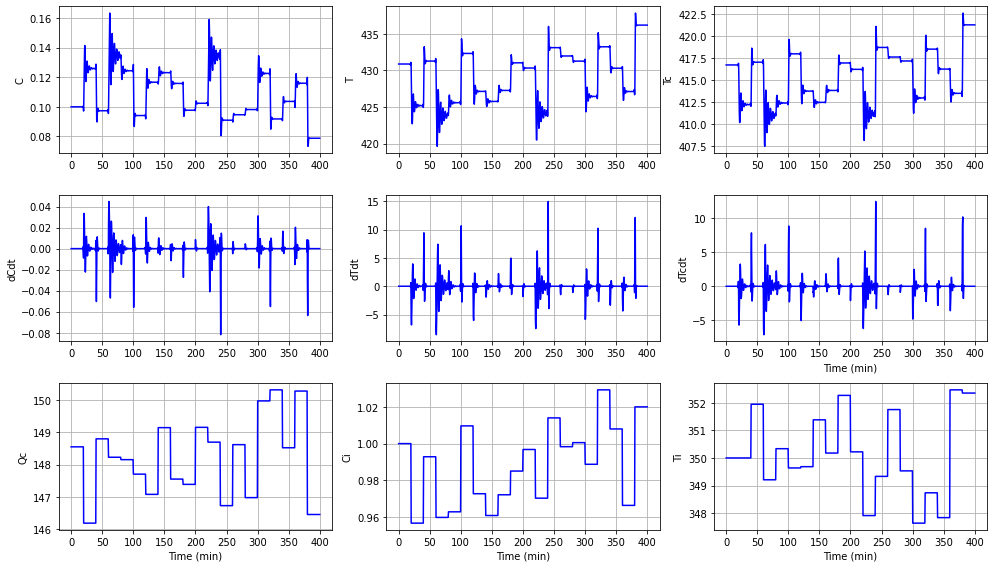

In [4]:
ctr = 1
plt.figure(figsize=(14, 8))
for k in cstr_df.columns:
    plt.subplot(3, 3, ctr)
    plt.plot(cstr_df[k].index, cstr_df[k].values,'b-')
    plt.ylabel(k)
    if ctr > 5:
        plt.xlabel('Time (min)')
    plt.grid()
    ctr += 1
    
plt.tight_layout()
plt.show()

In [5]:
cstr_df.head(10)

,C,T,Tc,dCdt,dTdt,dTcdt,Qc,Ci,Ti
0.000000,0.1,430.882699,416.723085,-1.454392e-14,-8.526513e-13,2.541620e-04,148.5502,1.0,350.0
0.155051,0.1,430.882702,416.723090,-5.395416e-08,1.987463e-05,2.760847e-05,148.5502,1.0,350.0
0.644949,0.1,430.882713,416.723099,-1.083963e-07,2.131900e-05,1.322602e-05,148.5502,1.0,350.0
1.000000,0.1,430.882718,416.723103,-7.101440e-08,9.609046e-06,1.538042e-05,148.5502,1.0,350.0
1.155051,0.1,430.882720,416.723104,-4.593310e-08,4.760035e-06,4.545103e-06,148.5502,1.0,350.0
1.644949,0.1,430.882719,416.723104,1.151306e-08,-4.786767e-06,-3.978616e-06,148.5502,1.0,350.0
2.000000,0.1,430.882717,416.723103,2.720766e-08,-5.868379e-06,-4.671474e-06,148.5502,1.0,350.0
2.155051,0.1,430.882716,416.723102,2.630139e-08,-4.997250e-06,-4.173805e-06,148.5502,1.0,350.0
2.644949,0.1,430.882715,416.723101,1.196505e-08,-1.317435e-06,-1.163643e-06,148.5502,1.0,350.0
3.000000,0.1,430.882715,416.723101,4.486265e-11,7.959089e-07,6.234939e-07,148.5502,1.0,350.0
